## Background
The first part builds two models (one fully connected and one CNN) trained and tested on MNIST dataset. The second part of the project uses the CIFAR-10 dataset which contains images for training a CNN model. The last part uses a pretrained model and tests it on the CIFAR-10 dataset.


Import necessary packages

In [ ]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

Train model using GPU

In [ ]:
rand_tensor = torch.rand(5,2)
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

# device = torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ----------- <Your code> ---------------
# Move rand_tensor and model onto the GPU device
rand_tensor = rand_tensor.to(device)
simple_model = simple_model.to(device)
# --------- <End your code> -------------
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cpu
model parameters are on [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
output is on cpu
input is on cuda:0
model parameters are on [device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0)]
output is on cuda:0


## 1.1 - Train and test functions
#### Arguments:
* For the `train` function, it takes the `model`, `loss_fn`, `optimizer`, `train_loader`, and `epoch` as arguments.
    * `model`: the classifier, or deep neural network, should be an instance of `nn.Module`.
    * `loss_fn`: the loss function instance. 
    * `optimizer`: should be an instance of `torch.optim.Optimizer`.
    * `train_loader`: should be an instance of `torch.utils.data.DataLoader`.
    * `epoch`: the current number of epoch. Only used for log printing.

* For the `test` function, it takes all the inputs above except for the optimizer (and it takes a test loader instead of a train loader).

In [ ]:
def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0)-> List:
    train_loss = []
    model.train()
    for batch_idx, (images, targets) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')
    assert len(train_loss) == len(train_loader)
    return train_loss

def test(model: nn.Module,
         loss_fn: nn.modules.loss._Loss,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0)-> Dict:
    model.eval()
    test_loss = 0
    correct = 0
    prediction = torch.tensor([]).to(device)
    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            test_loss += loss_fn(outputs, targets).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(targets.view_as(pred)).sum().item()
            prediction = torch.cat((prediction, pred.view(-1)))
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    test_stat = {"loss": test_loss, "accuracy": accuracy, "prediction": prediction}
    print(f"Test result on epoch {epoch}: total sample: {len(test_loader.dataset)}, Avg loss: {test_loss:.3f}, Acc: {100*accuracy:.3f}%")

    # dictionary includes loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" value should be a 1D tensor
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat


## 1.2 - Create FC network and CNN network

Training and Testing will be done using the MNIST dataset.

In [ ]:
# Download MNIST and transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 340226769.59it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 50242925.68it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 208536105.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9324781.58it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Build OurFC class and OurCNN class.
class OurFC(nn.Module):
    def __init__(self):
        super(OurFC, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class OurCNN(nn.Module):
    def __init__(self):
        super(OurCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(32*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# Train FC model
criterion = nn.CrossEntropyLoss()

start = time.time()
max_epoch = 4
fc_model = OurFC().to(device)
optimizer = optim.Adam(fc_model.parameters(), lr=0.001)
train_loss = []
for epoch in range(max_epoch):
    train_loss += train(fc_model, criterion, optimizer, train_loader, epoch)
    test(fc_model, criterion, test_loader, epoch)
    
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 0: [0/60000] Loss: 2.273
Epoch 0: [6400/60000] Loss: 0.565
Epoch 0: [12800/60000] Loss: 0.512
Epoch 0: [19200/60000] Loss: 0.229
Epoch 0: [25600/60000] Loss: 0.197
Epoch 0: [32000/60000] Loss: 0.214
Epoch 0: [38400/60000] Loss: 0.163
Epoch 0: [44800/60000] Loss: 0.177
Epoch 0: [51200/60000] Loss: 0.126
Epoch 0: [57600/60000] Loss: 0.069
Test result on epoch 0: total sample: 10000, Avg loss: 0.000, Acc: 94.250%
Epoch 1: [0/60000] Loss: 0.266
Epoch 1: [6400/60000] Loss: 0.185
Epoch 1: [12800/60000] Loss: 0.101
Epoch 1: [19200/60000] Loss: 0.233
Epoch 1: [25600/60000] Loss: 0.032
Epoch 1: [32000/60000] Loss: 0.102
Epoch 1: [38400/60000] Loss: 0.146
Epoch 1: [44800/60000] Loss: 0.064
Epoch 1: [51200/60000] Loss: 0.293
Epoch 1: [57600/60000] Loss: 0.389
Test result on epoch 1: total sample: 10000, Avg loss: 0.000, Acc: 95.820%
Epoch 2: [0/60000] Loss: 0.126
Epoch 2: [6400/60000] Loss: 0.059
Epoch 2: [12800/60000] Loss: 0.126
Epoch 2: [19200/60000] Loss: 0.053
Epoch 2: [25600/60000] Lo

In [ ]:
# train CNN model
start = time.time()
cnn_model = OurCNN().to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
train_loss = []
for epoch in range(1, max_epoch + 1):
    train_loss += train(cnn_model, criterion, optimizer, train_loader, epoch)
    test(cnn_model, criterion, test_loader, epoch)

end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 0: [0/60000] Loss: 2.307
Epoch 0: [6400/60000] Loss: 0.210
Epoch 0: [12800/60000] Loss: 0.128
Epoch 0: [19200/60000] Loss: 0.106
Epoch 0: [25600/60000] Loss: 0.125
Epoch 0: [32000/60000] Loss: 0.168
Epoch 0: [38400/60000] Loss: 0.058
Epoch 0: [44800/60000] Loss: 0.055
Epoch 0: [51200/60000] Loss: 0.030
Epoch 0: [57600/60000] Loss: 0.052
Test result on epoch 0: total sample: 10000, Avg loss: 0.000, Acc: 98.310%
Epoch 1: [0/60000] Loss: 0.045
Epoch 1: [6400/60000] Loss: 0.125
Epoch 1: [12800/60000] Loss: 0.114
Epoch 1: [19200/60000] Loss: 0.023
Epoch 1: [25600/60000] Loss: 0.077
Epoch 1: [32000/60000] Loss: 0.031
Epoch 1: [38400/60000] Loss: 0.128
Epoch 1: [44800/60000] Loss: 0.040
Epoch 1: [51200/60000] Loss: 0.005
Epoch 1: [57600/60000] Loss: 0.013
Test result on epoch 1: total sample: 10000, Avg loss: 0.000, Acc: 98.640%
Epoch 2: [0/60000] Loss: 0.148
Epoch 2: [6400/60000] Loss: 0.023
Epoch 2: [12800/60000] Loss: 0.023
Epoch 2: [19200/60000] Loss: 0.043
Epoch 2: [25600/60000] Lo

In [ ]:
ourfc = OurFC()
total_params = sum(p.numel() for p in ourfc.parameters())
print(f'OurFC has a total of {total_params} parameters')

ourcnn = OurCNN()
total_params = sum(p.numel() for p in ourcnn.parameters())
print(f'OurCNN has a total of {total_params} parameters')

## 2.1 - Train classifier on CIFAR-10 data

100%|██████████| 170498071/170498071 [00:13<00:00, 12398780.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


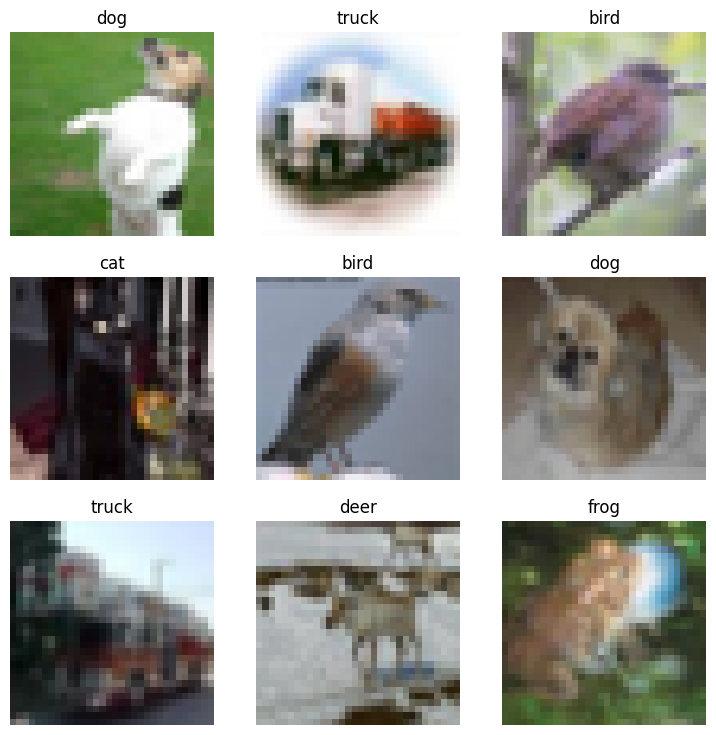

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the appropriate transform, load/download CIFAR10 train and test datasets with transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define trainloader and testloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=9, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=9, shuffle=False)

# Code to display images
batch_idx, (images, targets) = next(enumerate(train_loader)) #fix!!!!!
fig, ax = plt.subplots(3,3,figsize = (9,9))
for i in range(3):
    for j in range(3):
        image = images[i*3+j].permute(1,2,0)
        image = image/2 + 0.5
        ax[i,j].imshow(image)
        ax[i,j].set_axis_off()
        ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
fig.show()

## Task 2.2 - Create and train CNN

In [ ]:
# Create CNN network.
class OurCIFAR_CNN(nn.Module):
    def __init__(self):
        super(OurCIFAR_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(32*5*5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Train your neural network here.
start = time.time()
max_epoch = 4
net = OurCIFAR_CNN().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
train_loss = []
for epoch in range(max_epoch):
    train_loss += train(net, criterion, optimizer, train_loader, epoch)
output = test(net, criterion, test_loader, epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 0: [0/50000] Loss: 2.273
Epoch 0: [900/50000] Loss: 2.226
Epoch 0: [1800/50000] Loss: 1.962
Epoch 0: [2700/50000] Loss: 2.030
Epoch 0: [3600/50000] Loss: 1.941
Epoch 0: [4500/50000] Loss: 1.462
Epoch 0: [5400/50000] Loss: 1.589
Epoch 0: [6300/50000] Loss: 2.141
Epoch 0: [7200/50000] Loss: 1.520
Epoch 0: [8100/50000] Loss: 1.501
Epoch 0: [9000/50000] Loss: 1.904
Epoch 0: [9900/50000] Loss: 1.905
Epoch 0: [10800/50000] Loss: 1.201
Epoch 0: [11700/50000] Loss: 1.499
Epoch 0: [12600/50000] Loss: 1.264
Epoch 0: [13500/50000] Loss: 1.388
Epoch 0: [14400/50000] Loss: 1.221
Epoch 0: [15300/50000] Loss: 1.021
Epoch 0: [16200/50000] Loss: 1.172
Epoch 0: [17100/50000] Loss: 1.163
Epoch 0: [18000/50000] Loss: 1.096
Epoch 0: [18900/50000] Loss: 1.482
Epoch 0: [19800/50000] Loss: 1.370
Epoch 0: [20700/50000] Loss: 2.112
Epoch 0: [21600/50000] Loss: 1.705
Epoch 0: [22500/50000] Loss: 1.681
Epoch 0: [23400/50000] Loss: 1.595
Epoch 0: [24300/50000] Loss: 1.384
Epoch 0: [25200/50000] Loss: 1.131
E

## 2.3 - Plot misclassified test images

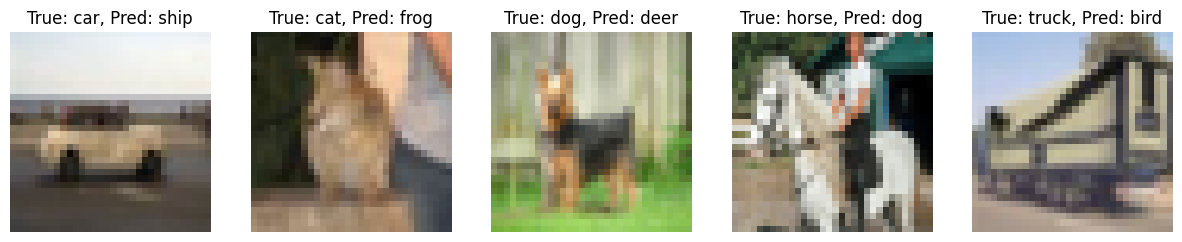

In [ ]:
total_images = 5
predictions = output['prediction']
targets = torch.tensor(test_set.targets)
misclassified = []
for class_id in [1, 3, 5, 7, 9]:
    class_idx = (targets == class_id).nonzero().squeeze()
    misclassified_idx = (predictions[class_idx] != class_id).detach().cpu()
    misclassified.append(class_idx[misclassified_idx][0].item())
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i, idx in enumerate(misclassified):
    image = test_set[idx][0].permute(1, 2, 0).detach().cpu()
    image = image/2 + 0.5
    ax[i].imshow(image)
    ax[i].set_title(f'True: {classes[targets[idx]]}, Pred: {classes[predictions[idx].int()]}')
    ax[i].set_axis_off()
fig.show()

Questions (0 points): Are the mis-classified images also misleading to human eyes?

## 3.1 - Load pretrained model

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


## 3.2 - Create data loaders for CIFAR-10

In [ ]:
# Create your dataloader here
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## 3.3 - Classify test data on pretrained model

In [ ]:
output = test(resnet18, criterion, test_loader, epoch)

Test result on epoch 3: total sample: 10000, Avg loss: 0.012, Acc: 0.030%


## 3.4 - Fine-tune the pretrained model for CIFAR-10

In [ ]:
# Directly train the whole model.
start = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)
max_epoch = 4
train_loss = []
for epoch in range(max_epoch):
    train_loss += train(resnet18, criterion, optimizer, train_loader, epoch)

test(resnet18, criterion, test_loader, epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 0: [0/50000] Loss: 10.016
Epoch 0: [6400/50000] Loss: 0.523
Epoch 0: [12800/50000] Loss: 0.476
Epoch 0: [19200/50000] Loss: 0.520
Epoch 0: [25600/50000] Loss: 0.597
Epoch 0: [32000/50000] Loss: 0.380
Epoch 0: [38400/50000] Loss: 0.610
Epoch 0: [44800/50000] Loss: 0.549
Epoch 1: [0/50000] Loss: 0.248
Epoch 1: [6400/50000] Loss: 0.279
Epoch 1: [12800/50000] Loss: 0.236
Epoch 1: [19200/50000] Loss: 0.184
Epoch 1: [25600/50000] Loss: 0.177
Epoch 1: [32000/50000] Loss: 0.219
Epoch 1: [38400/50000] Loss: 0.263
Epoch 1: [44800/50000] Loss: 0.140
Epoch 2: [0/50000] Loss: 0.250
Epoch 2: [6400/50000] Loss: 0.149
Epoch 2: [12800/50000] Loss: 0.202
Epoch 2: [19200/50000] Loss: 0.283
Epoch 2: [25600/50000] Loss: 0.304
Epoch 2: [32000/50000] Loss: 0.321
Epoch 2: [38400/50000] Loss: 0.162
Epoch 2: [44800/50000] Loss: 0.199
Epoch 3: [0/50000] Loss: 0.141
Epoch 3: [6400/50000] Loss: 0.205
Epoch 3: [12800/50000] Loss: 0.139
Epoch 3: [19200/50000] Loss: 0.143
Epoch 3: [25600/50000] Loss: 0.172
Epoc

In [ ]:
# Load another resnet18 instance, only unfreeze the outer layers.
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)
for param in resnet18.parameters():
    param.requires_grad = False
for param in resnet18.layer4.parameters():
    param.requires_grad = True
for param in resnet18.fc.parameters():
    param.requires_grad = True


In [ ]:
# Train the model
start = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)
max_epoch = 4
train_loss = []
for epoch in range(max_epoch):
    train_loss += train(resnet18, criterion, optimizer, train_loader, epoch)

test(resnet18, criterion, test_loader)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 0: [0/50000] Loss: 10.326
Epoch 0: [6400/50000] Loss: 0.379
Epoch 0: [12800/50000] Loss: 0.376
Epoch 0: [19200/50000] Loss: 0.600
Epoch 0: [25600/50000] Loss: 0.504
Epoch 0: [32000/50000] Loss: 0.532
Epoch 0: [38400/50000] Loss: 0.598
Epoch 0: [44800/50000] Loss: 0.278
Epoch 1: [0/50000] Loss: 0.200
Epoch 1: [6400/50000] Loss: 0.177
Epoch 1: [12800/50000] Loss: 0.261
Epoch 1: [19200/50000] Loss: 0.263
Epoch 1: [25600/50000] Loss: 0.385
Epoch 1: [32000/50000] Loss: 0.233
Epoch 1: [38400/50000] Loss: 0.391
Epoch 1: [44800/50000] Loss: 0.125
Epoch 2: [0/50000] Loss: 0.203
Epoch 2: [6400/50000] Loss: 0.117
Epoch 2: [12800/50000] Loss: 0.056
Epoch 2: [19200/50000] Loss: 0.219
Epoch 2: [25600/50000] Loss: 0.247
Epoch 2: [32000/50000] Loss: 0.052
Epoch 2: [38400/50000] Loss: 0.191
Epoch 2: [44800/50000] Loss: 0.058
Epoch 3: [0/50000] Loss: 0.070
Epoch 3: [6400/50000] Loss: 0.131
Epoch 3: [12800/50000] Loss: 0.166
Epoch 3: [19200/50000] Loss: 0.016
Epoch 3: [25600/50000] Loss: 0.028
Epoc